# Importazione dati
Questo notebook verrà usato per l'importazione di tutti i database che ci servono \
I dati saranno salvati quindi nella cartella data\processed

In [27]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from functions import *

import make_dataset as m_d
### Per usare multi cartelle
#import sys
#sys.path.append('./../src')
#print(sys.path)

## Grid data

Index(['cellId', 'geometry'], dtype='object')


,cellId,geometry
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179..."
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157..."
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136..."
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100..."
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079..."
...,...,...
6570,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735..."
6571,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703..."
6572,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666..."
6573,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634..."


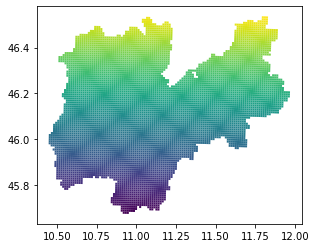

In [28]:
#GRID
grid=m_d.safe_import("grid")

grid.plot('cellId')
grid

## Non da' problemi, poi dovrò mergiarlo

# Social Pulse

In [29]:
#Questo fallisce ad importare, come mostrato a lezione 24
import json
tweets_json = json.load( open(m_d.data_path / m_d.files['twitter'][0]) )

tweets = gpd.GeoDataFrame(tweets_json['features'])

#Creiamo il punto smontando la casella point
from shapely.geometry import Point
tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
tweets.drop(columns=['geomPoint.geom'],inplace=True)

#Droppo roba inutile
tweets.drop(columns=['municipality.acheneID'],inplace=True)
tweets.drop(columns=['entities'],inplace=True)


print(tweets.shape)
#tweets.dtypes
tweets.head(10)


(27941, 6)


,created,timestamp,user,municipality.name,language,geometry
0,2013-11-01T00:04:16,1383260656,5fd4f31f75,Trento,it,POINT (11.13000 46.07000)
1,2013-11-01T00:01:14,1383260474,68c0e98182,Pinzolo,tl,POINT (10.83000 46.23000)
2,2013-11-01T00:43:03,1383262983,abe21fc052,Cavalese,en,POINT (11.46000 46.29000)
3,2013-11-01T00:38:37,1383262717,94d1efbbfd,Rovereto,it,POINT (11.04000 45.89000)
4,2013-11-01T00:45:40,1383263140,d261d03075,San Michele all'Adige,ru,POINT (11.12000 46.20000)
5,2013-11-01T00:45:17,1383263117,46c436c9f1,Trento,es,POINT (11.13000 46.06000)
6,2013-11-05T00:52:09,1383609129,cd79302fa7,Rovereto,und,POINT (11.03000 45.89000)
7,2013-11-01T01:25:10,1383265510,5fd4f31f75,Trento,it,POINT (11.13000 46.07000)
8,2013-11-01T01:38:40,1383266320,5fd4f31f75,Trento,pt,POINT (11.13000 46.07000)
9,2013-11-01T01:28:37,1383265717,4294c6de56,Pinzolo,en,POINT (10.82000 46.23000)


In [37]:
## I have to create a Target
# The target considers the numer of interation at a given hour in a particular day

# support function
col=["month","day","hours","temperature", "rain" ]
Tw_final=pd.DataFrame(columns=col)

N=len(tweets["created"])  #Numero tweets

print(Tw_final)
for i in range(0,N):
    #Inizializzo riga o crasha
    Tw_final.loc[i]="NaN"
    
    #Tempo
    #Tw_final.loc[i]["year"]=int(tweets.loc[i]["created"][0:4])  #Chemmifrega dell'anno, tutti uguali
    Tw_final.loc[i]["month"]=int(tweets.loc[i]["created"][5:7])
    Tw_final.loc[i]["day"]=int(tweets.loc[i]["created"][8:10])
    Tw_final.loc[i]["hours"]=int(tweets.loc[i]["created"][11:13])+0.5*(int(tweets.loc[i]["created"][14:16])>=30)
    
    """
    #Temperatura, per ricavare questa usiamo la stazione più vicina al tweet (sfortunamente il Trentino non ne ha tante)
    dmin=10000000000
    for st in weather.groupby(station):
        d=tweets["geometry"].distance(st[geometry])
    gdf['distance'] = gdf['centroid'].distance(queens_point)
    Tw_final.loc[i]["temperature"]=int(tweets.loc[i]["created"][5:7])
    """
    
Tw_final


Empty DataFrame
Columns: [month, day, hours, temperature, rain]
Index: []


,month,day,hours,temperature,rain
0,11,1,0.0,NaN,NaN
1,11,1,0.0,NaN,NaN
2,11,1,0.5,NaN,NaN
3,11,1,0.5,NaN,NaN
4,11,1,0.5,NaN,NaN
...,...,...,...,...,...
27936,12,31,0.0,NaN,NaN
27937,12,29,13.0,NaN,NaN
27938,11,19,0.5,NaN,NaN
27939,11,23,9.5,NaN,NaN


# Weather

In [30]:
"""
#Fallisce ad importare
weather=m_d.safe_import("weather")
weather
"""
weather_json = json.load( open(m_d.data_path / m_d.files['weather'][0]) )
print(tweets_json.keys())
print(tweets_json['crs'])
print(tweets_json['type'])


#Come prima ho metadati
weather = gpd.GeoDataFrame(weather_json['features'])


#Elimino le colonne del vento (dati molto incompleti)
weather.drop(weather.columns[list(range(202,298))], axis=1, inplace=True)
weather.drop(columns=['minWind', "maxWind"], inplace=True)

#Svolgiamo infine i punti geometrici
weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather.drop(columns=['geomPoint.geom'],inplace=True)

pd.set_option('display.max_columns', None)
weather.head(10)

dict_keys(['crs', 'type', 'features'])
{'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}
SlicedDataCollection


,station,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,temperatures.0000,temperatures.0015,temperatures.0030,temperatures.0045,temperatures.0100,temperatures.0115,temperatures.0130,temperatures.0145,temperatures.0200,temperatures.0215,temperatures.0230,temperatures.0245,temperatures.0300,temperatures.0315,temperatures.0330,temperatures.0345,temperatures.0400,temperatures.0415,temperatures.0430,temperatures.0445,temperatures.0500,temperatures.0515,temperatures.0530,temperatures.0545,temperatures.0600,temperatures.0615,temperatures.0630,temperatures.0645,temperatures.0700,temperatures.0715,temperatures.0730,temperatures.0745,temperatures.0800,temperatures.0815,temperatures.0830,temperatures.0845,temperatures.0900,temperatures.0915,temperatures.0930,temperatures.0945,temperatures.1000,temperatures.1015,temperatures.1030,temperatures.1045,temperatures.1100,temperatures.1115,temperatures.1130,temperatures.1145,temperatures.1200,temperatures.1215,temperatures.1230,temperatures.1245,temperatures.1300,temperatures.1315,temperatures.1330,temperatures.1345,temperatures.1400,temperatures.1415,temperatures.1430,temperatures.1445,temperatures.1500,temperatures.1515,temperatures.1530,temperatures.1545,temperatures.1600,temperatures.1615,temperatures.1630,temperatures.1645,temperatures.1700,temperatures.1715,temperatures.1730,temperatures.1745,temperatures.1800,temperatures.1815,temperatures.1830,temperatures.1845,temperatures.1900,temperatures.1915,temperatures.1930,temperatures.1945,temperatures.2000,temperatures.2015,temperatures.2030,temperatures.2045,temperatures.2100,temperatures.2115,temperatures.2130,temperatures.2145,temperatures.2200,temperatures.2215,temperatures.2230,temperatures.2245,temperatures.2300,temperatures.2315,temperatures.2330,temperatures.2345,precipitations.0000,precipitations.0015,precipitations.0030,precipitations.0045,precipitations.0100,precipitations.0115,precipitations.0130,precipitations.0145,precipitations.0200,precipitations.0215,precipitations.0230,precipitations.0245,precipitations.0300,precipitations.0315,precipitations.0330,precipitations.0345,precipitations.0400,precipitations.0415,precipitations.0430,precipitations.0445,precipitations.0500,precipitations.0515,precipitations.0530,precipitations.0545,precipitations.0600,precipitations.0615,precipitations.0630,precipitations.0645,precipitations.0700,precipitations.0715,precipitations.0730,precipitations.0745,precipitations.0800,precipitations.0815,precipitations.0830,precipitations.0845,precipitations.0900,precipitations.0915,precipitations.0930,precipitations.0945,precipitations.1000,precipitations.1015,precipitations.1030,precipitations.1045,precipitations.1100,precipitations.1115,precipitations.1130,precipitations.1145,precipitations.1200,precipitations.1215,precipitations.1230,precipitations.1245,precipitations.1300,precipitations.1315,precipitations.1330,precipitations.1345,precipitations.1400,precipitations.1415,precipitations.1430,precipitations.1445,precipitations.1500,precipitations.1515,precipitations.1530,precipitations.1545,precipitations.1600,precipitations.1615,precipitations.1630,precipitations.1645,precipitations.1700,precipitations.1715,precipitations.1730,precipitations.1745,precipitations.1800,precipitations.1815,precipitations.1830,precipitations.1845,precipitations.1900,precipitations.1915,precipitations.1930,precipitations.1945,precipitations.2000,precipitations.2015,precipitations.2030,precipitations.2045,precipitations.2100,precipitations.2115,precipitations.2130,precipitations.2145,precipitations.2200,precipitations.2215,precipitations.2230,precipitations.2245,precipitations.2300,precipitations.2315,precipitations.2330,precipitations.2345,geometry
0,T0071,905,2013-11-01,1383260400,4.5,12.3,False,8.4,8.3,8.2,8.1,8.2,8.2,8.3,8.1,8.0,7.7,7.5,7.6,7.8,7.8,7.5,7.0,6.6,6.1,6.3,6.1,5.7,5.7,5.0,4.9,4.9,4.7,4.9,5.0,5.0,4.5,4.8,4.9,4.6,5.1,5.0,5.1,5.5,5.4,5.9,7.0,7.5,7.7,8.6,9.1,9.8,11.2,11.6,11.5,11.2,11.5,11.6,11.8,1

<AxesSubplot:>

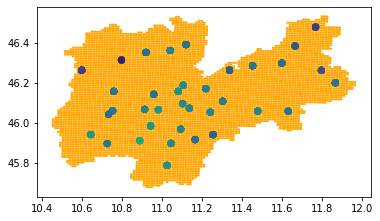

In [31]:
ax = grid.plot(color="orange")
weather.plot(column='maxTemperature',ax=ax)


In [32]:
#Rimane un problema, le temperature non sono svolte
#Visto che non è facile da svolgere uso una funzione

#Mi serve in primis creare un database delle stazioni della temperatura
stazioni = weather['station'].unique()
coltmpr=["station", "elevation", "temperature", "precipitations", "geometry"]

station_stats=gpd.GeoDataFrame(columns=coltmpr)

colweather=weather.keys()

for idx,stat in enumerate(stazioni):
    station_stats.loc[idx]="NaN"
    
    temp = pd.DataFrame(weather[weather['station']==stat])
    
    
    #Costruiamo una mappa temporale per displayare la temperatura
    #Il tempo 0 è 1-11-2013 ore 0:00, e poi conto in minuti
    #L'ultimo elemento sarà un vettore con un integer in input e e una temperatura in output

    temp['date'] =pd.to_datetime(temp["date"])
    #temp.sort('date')    #Sortiamo per sicurezza

    assert(len(temp["station"])==61), "Warning: length of the dataset does not match expected value"

    v=-1000*np.ones(10000)
    #Chiedo venia per la python-unfriendlyness
    for j,st in enumerate(temp.index):
        for i,t in enumerate(colweather[7:7+4*24]):
            v[(j*4*24+i)*15]=temp.loc[st][t]
    #Questo mappa effettivamente le colonne
    
    
    station_stats.loc[idx]["geometry"]=temp.loc[temp.index[0],:]["geometry"]
    station_stats.loc[idx]["station"]=stat
    station_stats.loc[idx]["elevation"]=temp.loc[temp.index[0],:]["elevation"]
    station_stats.loc[idx]["temperature"]=v
    #Con temperature che sarà un dizionario che offre le temperature

station_stats



IndexError: index 10005 is out of bounds for axis 0 with size 10000

# Precipitazioni

In [ ]:
#Questo si comporta bene
#Non è utile importare i data availability tendenzialmente
colnames = ['time', 'NO_IDEA', 'intensity(?)']


dummy=m_d.safe_import('precip')
#Problema: il primo dato vien preso come dizionario
#Converto colonne
dummy=dummy.rename(columns={'201311010000': 'time', "2383": 'NO_IDEA', "1" : 'intensity(?)'})

#Riaggiungo il primo dato
precipitation=appforth(dummy,[201311010000,2383,1])

precipitation

# Electro

In [ ]:
# devo prima unire i due dataset di line set -> nov e poi nov -> dicembre

#Problema: il primo dato vien preso come dizionario
#Converto colonne
temp = m_d.safe_import('SET-2')
temp=temp.rename(columns={'DG1000420': 'LINESET', "2013-12-01 00:00": 'Timestamp', "36.719997" : 'Value Amp'})
#Riaggiungo il primo dato
electro=appforth(temp,['DG1000420','2013-12-01 00:00',36.719997])

temp1 = m_d.safe_import('SET-2')
temp1=temp1.rename(columns={'DG1000420': 'LINESET', "2013-11-01 00:00": 'Timestamp', "37.439999" : 'Value Amp'})
#Riaggiungo il primo dato
electro_1=appforth(temp1,['DG1000420','2013-12-01 00:00',36.719997])

electro.append(electro_1)

electro
#del temp
#del temp1
#del electro_1
#
lines = m_d.safe_import('SET-lines')
electro = electro.merge(right=lines, how='outer')


#Ci sono incompatibilità tra i record salvati quindi li droppo cattivo
electro.dropna()

## ADMINISTRATIVE REGIONS

In [33]:
adm_reg=m_d.safe_import('regions')

adm_reg.plot("Shape_Area")
adm_reg.head(5)

DriverError: data\raw\Com01012013\Com01012013_WGS84.shp: No such file or directory

In [34]:
#Convertiamo alla vera patria
adm_reg=adm_reg[adm_reg["COD_PROV"]==22]
adm_reg.plot("Shape_Area")

NameError: name 'adm_reg' is not defined

## NOTE PER RIALLACCIARE I DATI:
I dati vanno riallacciati mediante appropriata conversione, dovrò
1) Discretizzare il tempo, scegliere un tempo base per fare un binning dei dati  \
2) Collegare tramite la grid i dati ad un punto del plot  (binning su posizioni) \
3) Svolgo la divisione in minuti della tabella weather, dovrò abbastanza binnare comunque \
4) Svolgo i tweets vanno binnati agli intervalli temporali

Alt: creo una funzione temperatura che sia continua (connetto linearmente punti distanti 15 minuti, non dovrebbero cambiar molto), e poi tratto il tempo continuo

# Unione di Databases
Passo 1: creare un database dei tweets; a ogni tweet associo tempo atmosferico e temperatura \
FORMATO: tempo,  \
Il tempo viene binnato in 30 minuti (mediamente abbiamo sui 20 tweets all'ora), visto che i dati sono ottenuti ogni 10 o 15 perderei informazioni ma per i tweets uso diretto il valore dalla tabella)

In [35]:
#Mi serve in primis creare un database delle stazioni della temperatura
stazioni = weather['station'].unique()
print(stazioni)
coltmpr=["station", "elevation", "measurements", "position"]

station_stats=pd.DataFrame(columns=coltmpr)

colweather=weather.keys()

for idx,stat in enumerate(stazioni):
    station_stats.loc[idx]="NaN"
    temp = weather[weather['station']==stat]

    #Costruiamo una mappa temporale per displayare la temperatura
    #Il tempo 0 è 1-11-2013 ore 0:00, e poi conto in minuti
    #L'ultimo elemento sarà un vettore con un integer in input e e una temperatura in output
    
    #temp['date'] =pd.to_datetime(temp["date"])
    #temp.sort('date')    #Sortiamo per sicurezza
    
    if(len(temp["station"])<61):
        print("La vita è triste")
        
    v=-1000*np.ones(1000000)
    #Chiedo venia per la python-unfriendlyness
    for j,st in enumerate(temp.Index()):
        for i,t in enumerate(colweather[7:7+4*24]):
            print(t)
            print(temp)
            v[(j*4*24+i)*15]=temp.loc[st][t]
    #Questo mappa effettivamente le colonne
    
    station_stats[idx]["postion"]=temp.loc[0]["geometry"]
    station_stats[idx]["station"]=stat
    station_stats[idx]["elevation"]=temp.loc[0]["elevation"]
    station_stats[idx]["temperature"]=v
    #Con temperature che sarà un dizionario che offre le temperature

station_stats

['T0071' 'T0032' 'T0096' 'T0074' 'T0101' 'T0118' 'T0129' 'T0236' 'T0135'
 'T0139' 'T0146' 'T0147' 'T0182' 'T0175' 'T0189' 'T0179' 'T0210' 'T0360'
 'T0367' 'T0383' 'T0389' 'T0379' 'T0392' 'T0397' 'T0405' 'T0401' 'T0402'
 'T0408' 'T0409' 'T0414' 'T0428' 'T0419' 'T0431' 'T0437' 'T0469' 'T0450']


AttributeError: 'GeoDataFrame' object has no attribute 'Index'

Empty DataFrame
Columns: [month, day, hours, temperature, rain]
Index: []


,month,day,hours,temperature,rain
0,11,1,0.0,NaN,NaN
1,11,1,0.0,NaN,NaN
2,11,1,0.5,NaN,NaN
3,11,1,0.5,NaN,NaN
4,11,1,0.5,NaN,NaN
...,...,...,...,...,...
27936,12,31,0.0,NaN,NaN
27937,12,29,13.0,NaN,NaN
27938,11,19,0.5,NaN,NaN
27939,11,23,9.5,NaN,NaN


## EDA




In [ ]:
#

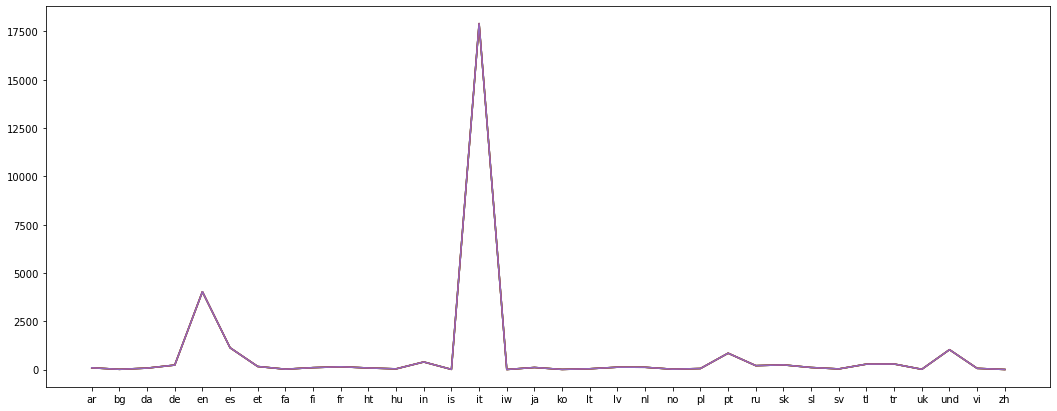

In [12]:
plt.figure(figsize = (18,7))

plt.plot(tweets.groupby("language").count())